In [23]:
########################
# RUN THIS FIRST
########################

# Code used for generating 2 lists of absolute paths; 1 for segmentation files, 1 for labelmap files

# The resulting lists will be fed into the 'process_files' function to copy/rename files and convert segmentation
    # files to labelmaps (retaining 'A' & 'V' labels only)

import os
import glob
import SimpleITK as sitk

#Recursion through directories, searches for files based on file name and extension, saves path to each matching file to one of two lists
def find_files_by_extension_and_prefix(root_folder, extension, prefix):
    segmentation_files = []
    final_files = []

    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            
            #S-Segmentation and S-Final (without 'label' in file name) in one list, S-Final with 'label' in file name in other list
            if filename.endswith(extension) and os.path.basename(dirpath).startswith(prefix):
                #".replace(os.path.sep, '/')" is used to corrent the backslashes in Windows' file paths to the Unix forwardslash
                full_path = os.path.join(dirpath, filename).replace(os.path.sep, '/')
                if filename.startswith("S-Segmentation"):
                    segmentation_files.append(full_path)
                elif filename.startswith("S-Final") and "label" not in filename:
                    segmentation_files.append(full_path)
                elif filename.startswith("S-Final") and "label" in filename:
                    final_files.append(full_path)

    return segmentation_files, final_files

#Copy files in segmentation & label lists generated by the 'find_files_by_extension_and_prefix' function
def copy_and_rename_files(source_dir, destination_dir):
    for root, _, files in os.walk(source_dir):
        for filename in files:
            source_file_path = os.path.join(root, filename)
            parent_dir = os.path.basename(root)
            new_filename = filename + '_' + parent_dir  # Appending parent directory name to the filename
            destination_file_path = os.path.join(destination_dir, new_filename)
            shutil.copy2(source_file_path, destination_file_path)

######################################################################

# Edit this path to point to the desired parent directory to begin searching for segmentation and labelmap files

#root_folder = "Y:/public_resources/RA4-Project/D-Images/MESAL-3/2-Checked-Done-Temp/Done"
root_folder = "Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done"

# Testing path:
#root_folder = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/"
#root_folder = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/"

######################################################################

extension = ".nrrd"
#Specifies directory name prefix to look for - will add '99-' later 
prefix = "88-"

# Creates two lists of absolute paths to each *.nrrd file within the specified parent directory (root_folder)
segmentation_files, final_files = find_files_by_extension_and_prefix(root_folder, extension, prefix)

print("Segmentation files starting with 'S-Segmentation':")
for file in segmentation_files:
    print(file)

print("\nLabelmap files starting with 'S-Final':")
for file in final_files:
    print(file)

Segmentation files starting with 'S-Segmentation':
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Final-1.nrrd
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Final-2.nrrd
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-1.nrrd
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-2.nrrd
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_3_53062428/MarkUps/88-Jensen/S-Segmentation-3.nrrd
Y:/public_resources/RA4-Project/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-22-0.5_A_80KV_Qr40d_

C:\Users\Adam\AppData\Local\Temp\ipykernel_18876\313470938.py:239: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


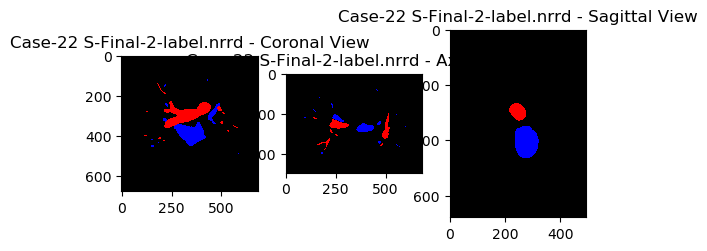

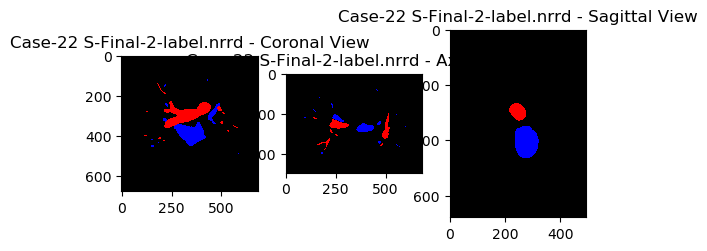

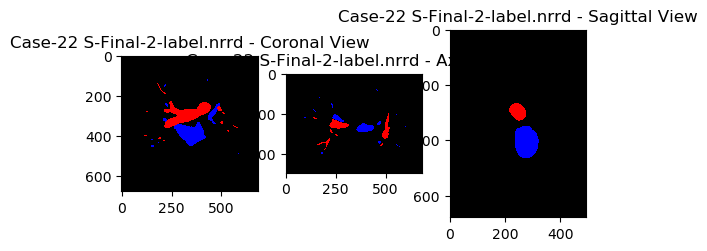

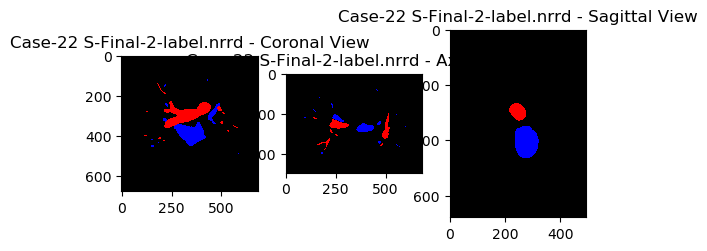

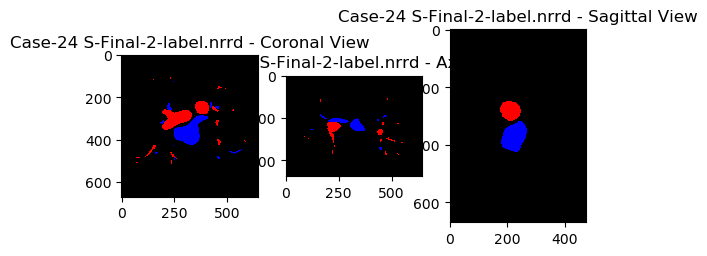

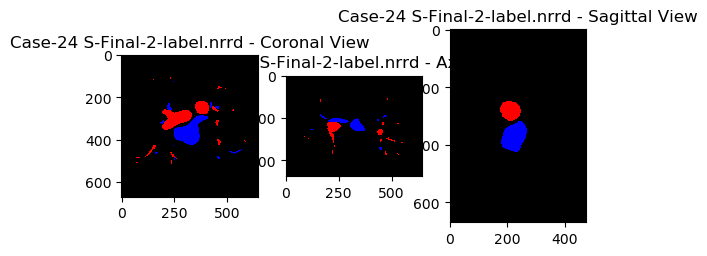

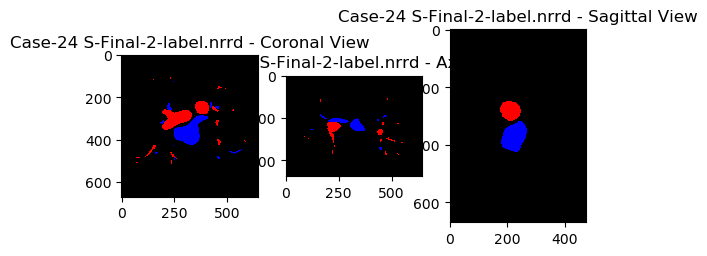

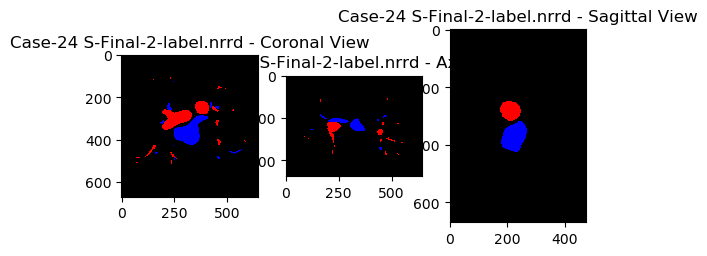

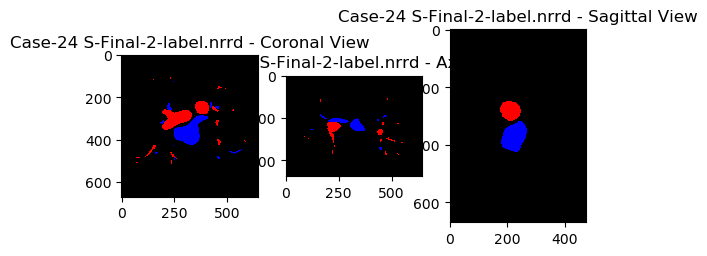

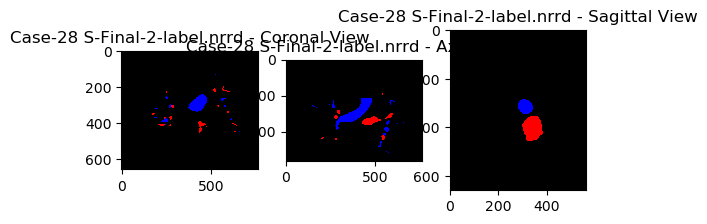

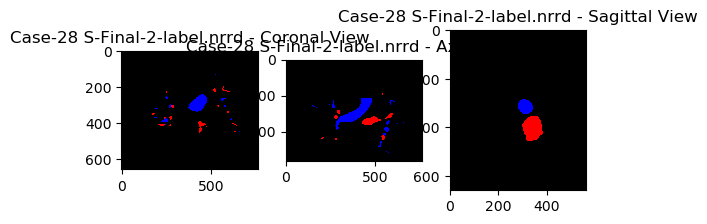

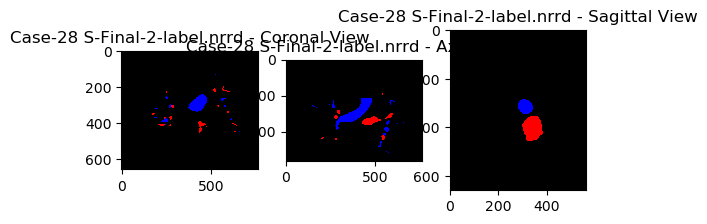

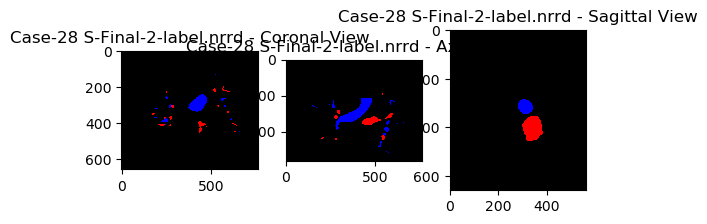

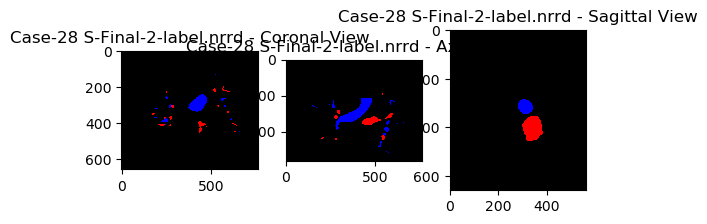

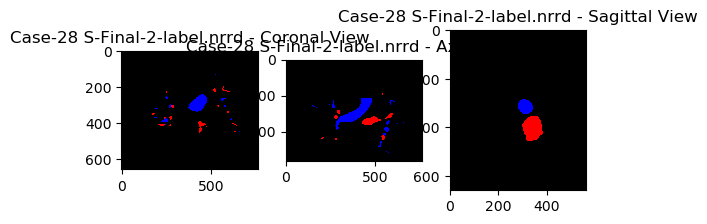

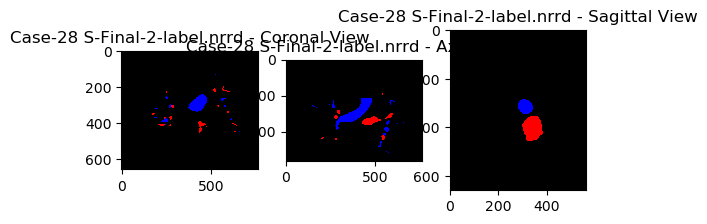

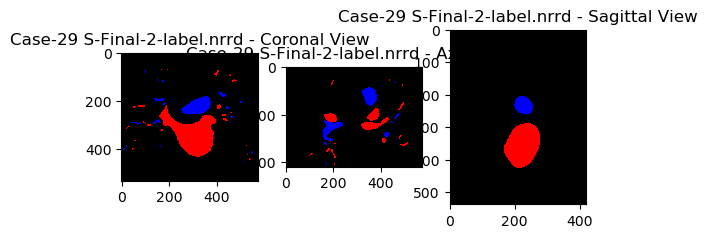

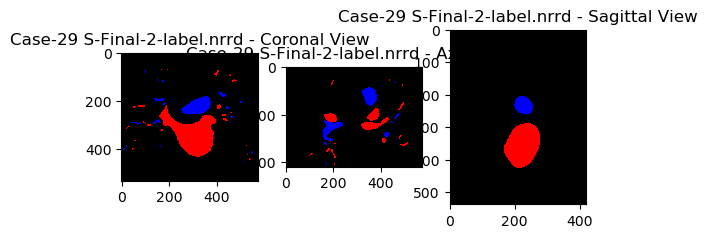

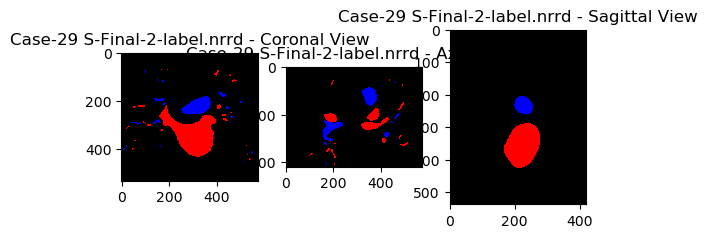

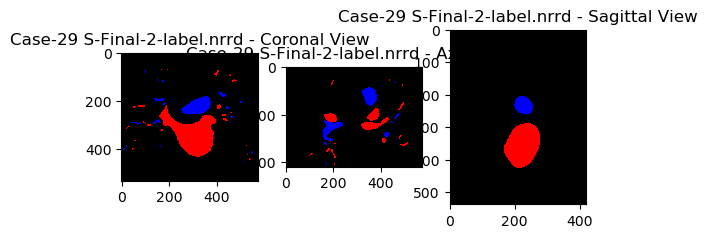

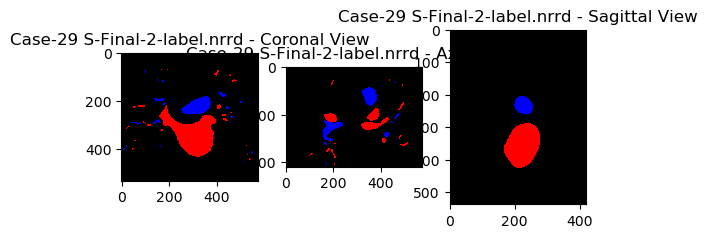

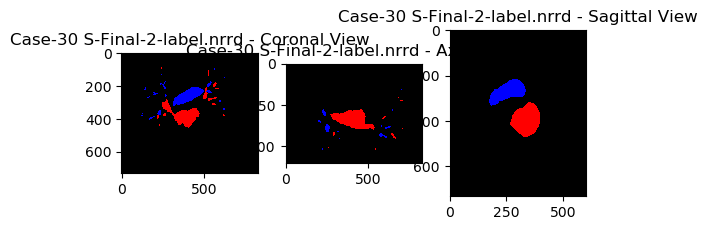

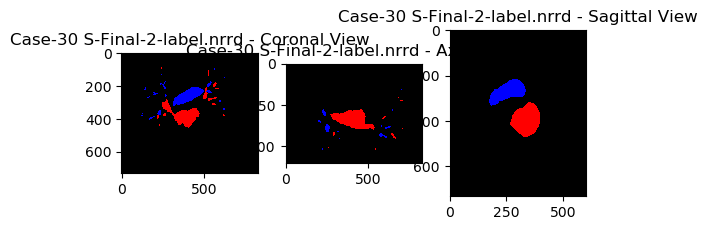

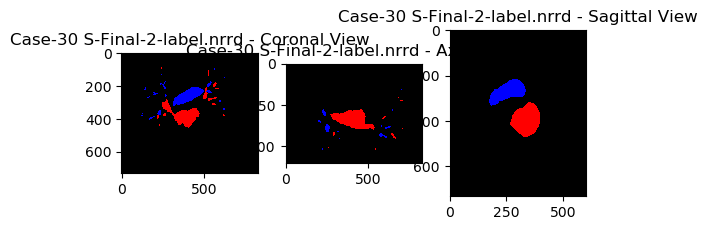

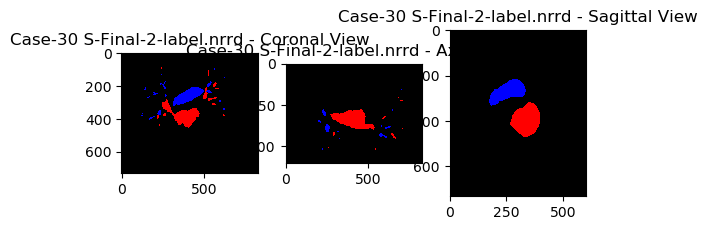

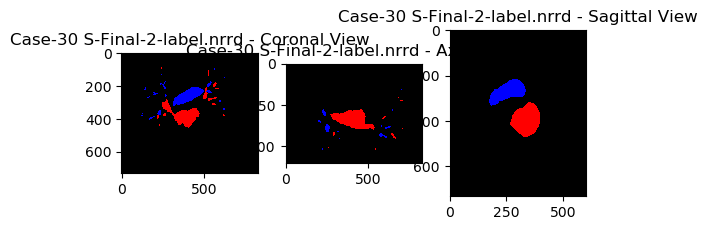

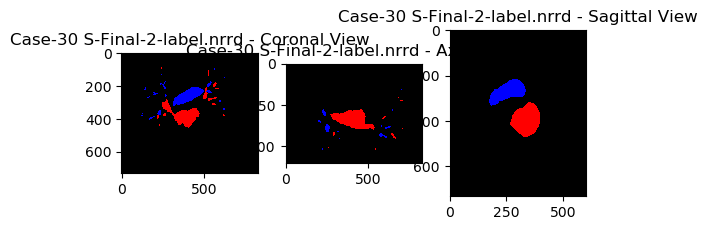

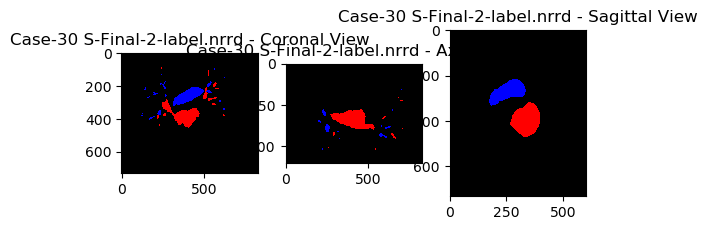

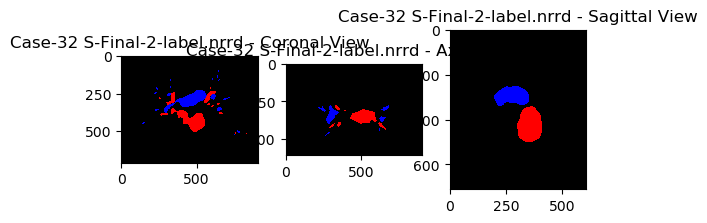

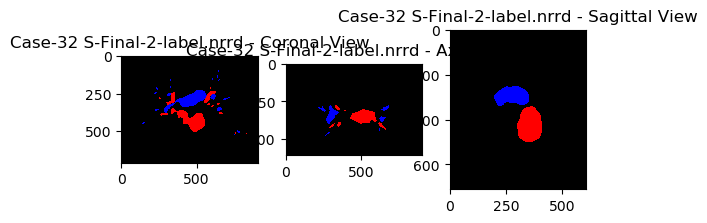

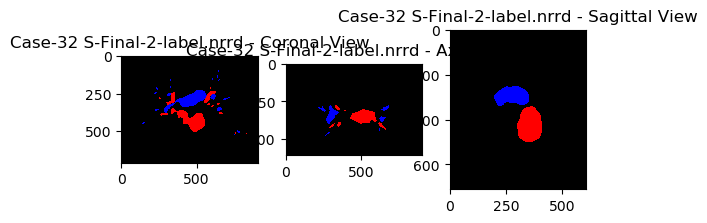

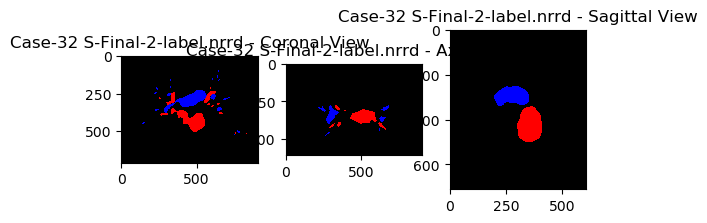

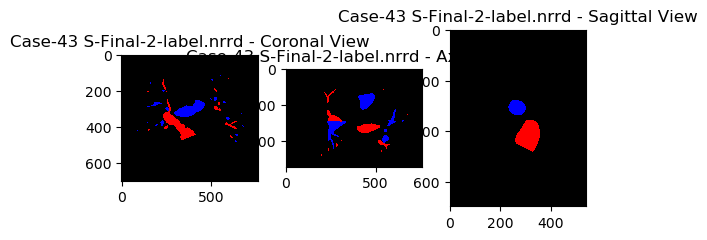

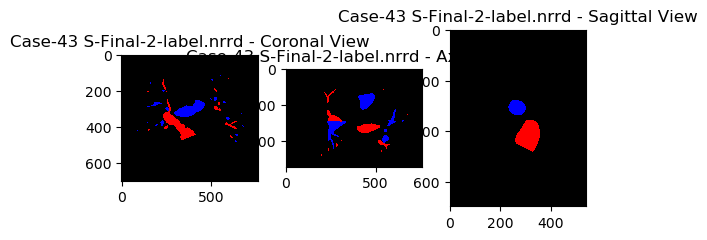

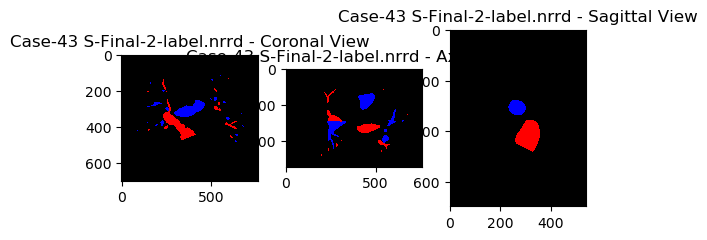

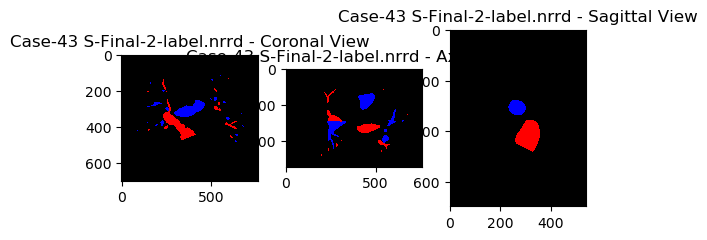

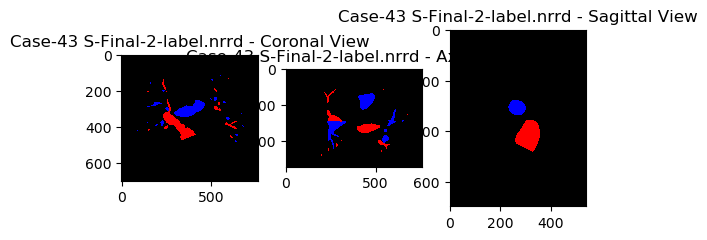

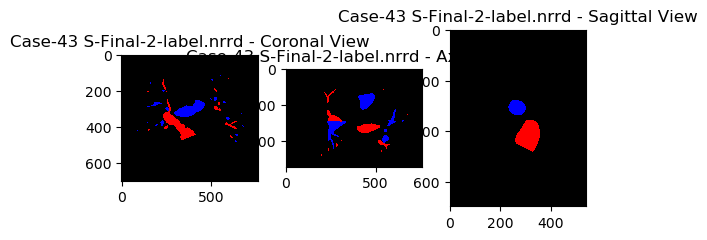

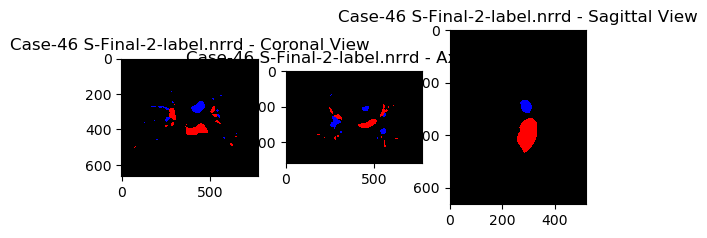

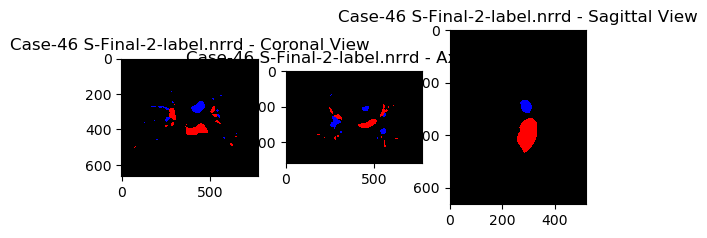

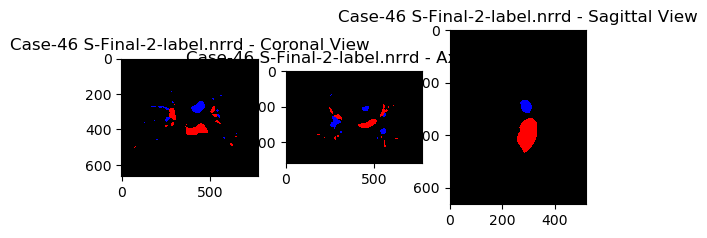

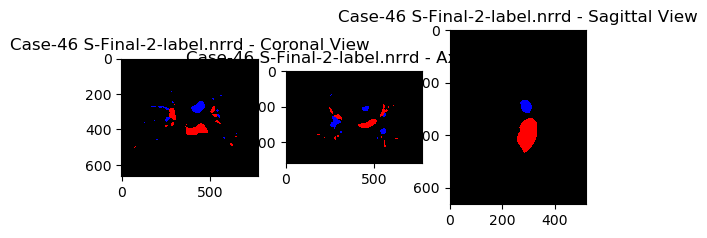

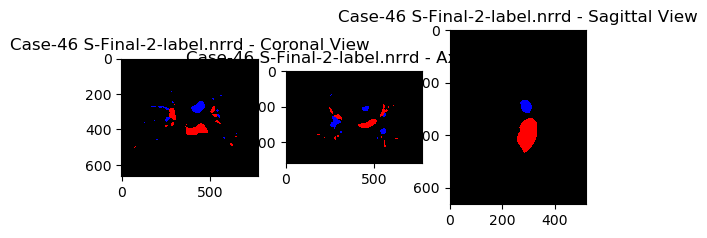

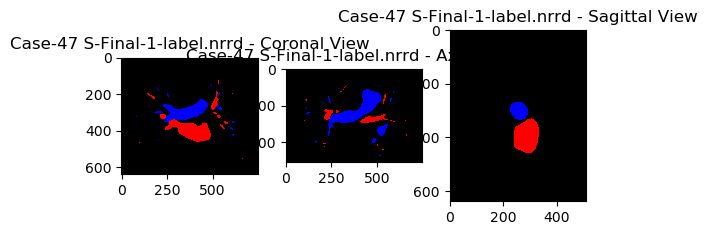

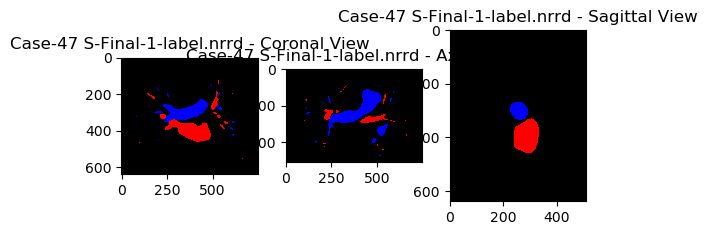

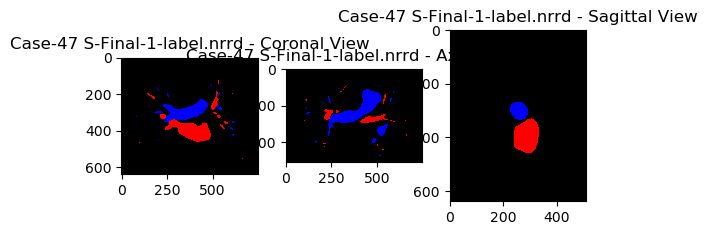

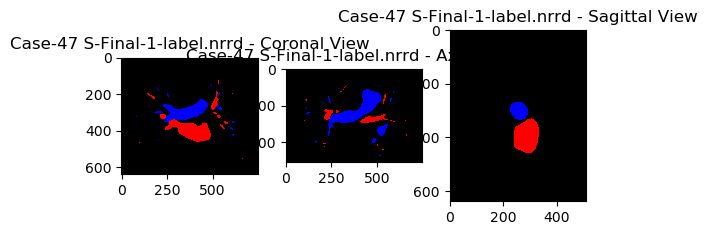

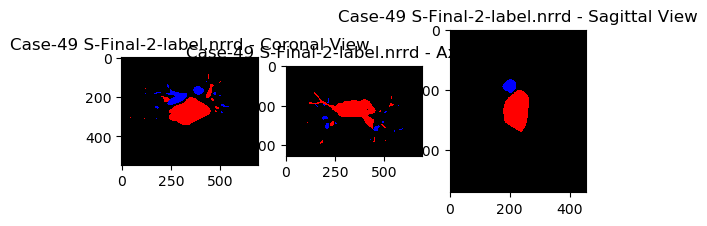

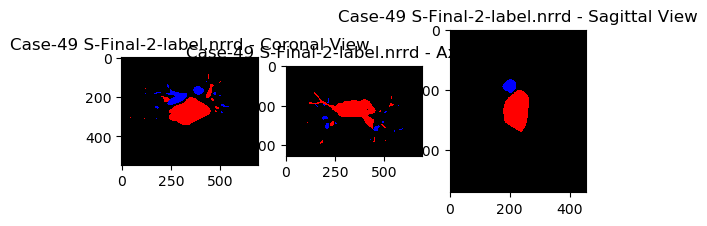

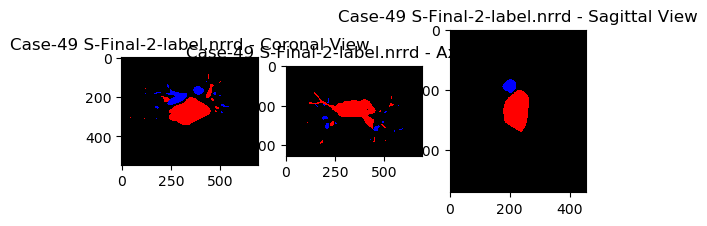

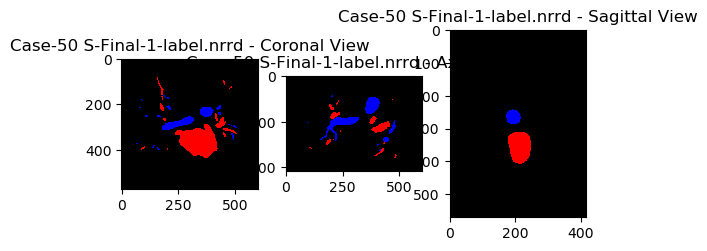

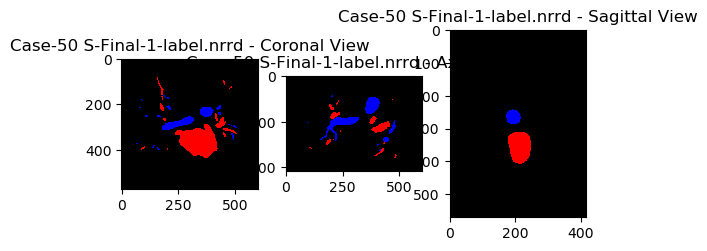

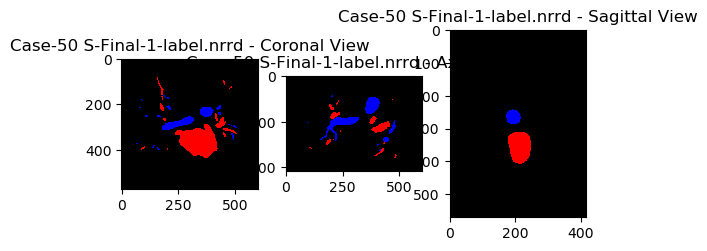

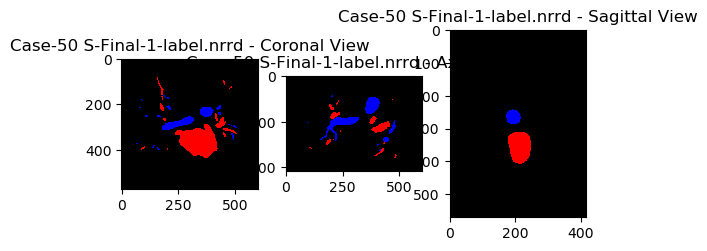

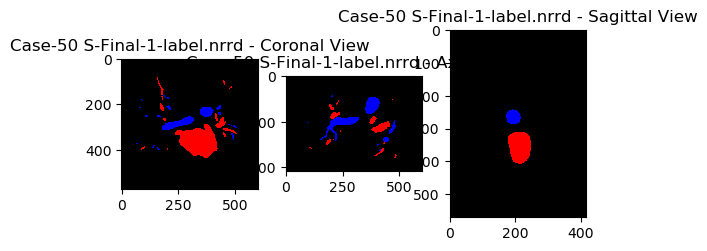

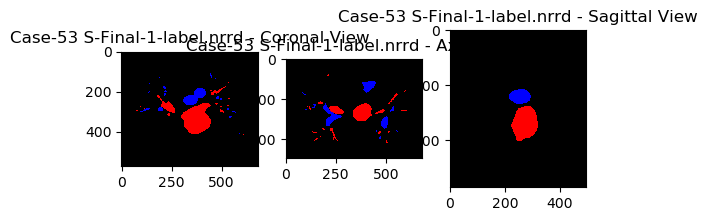

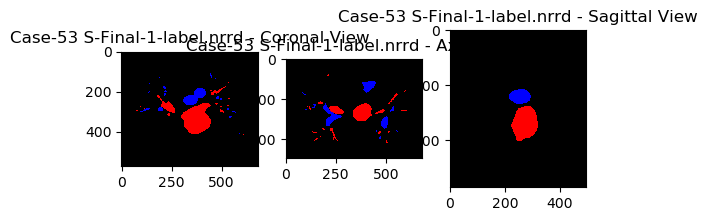

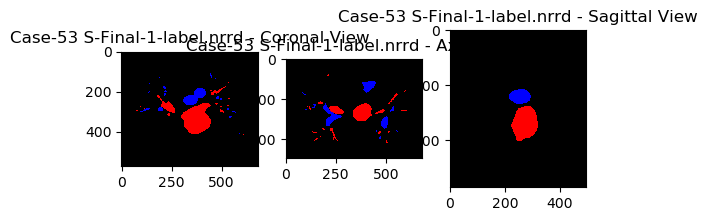

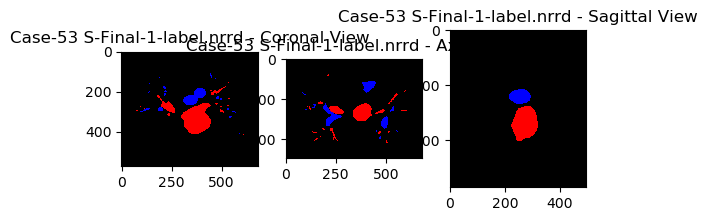

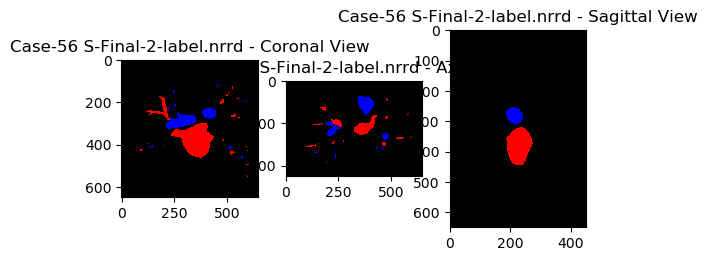

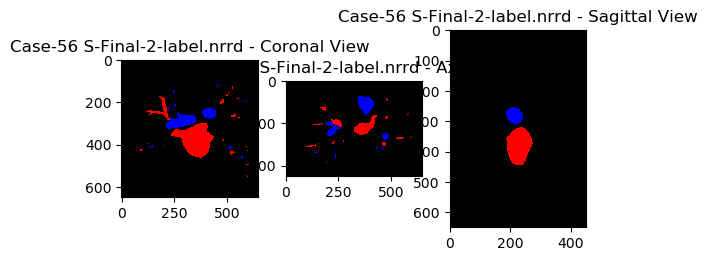

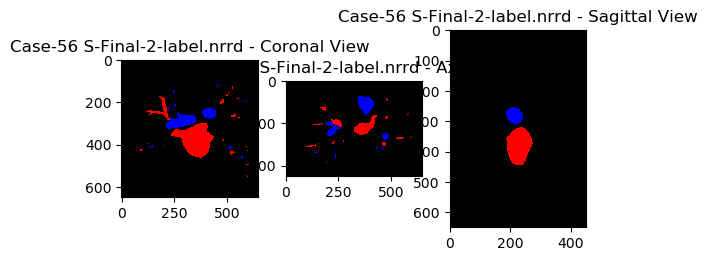

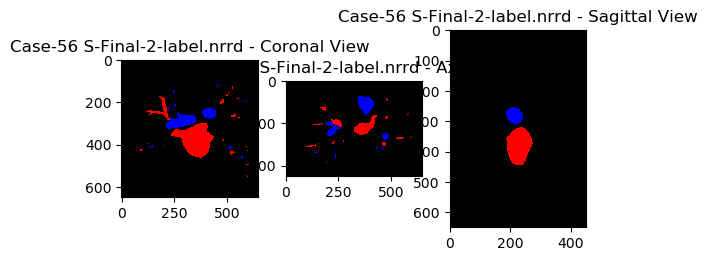

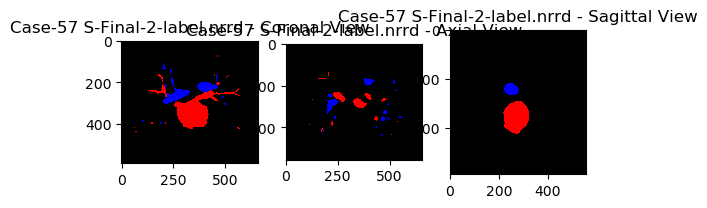

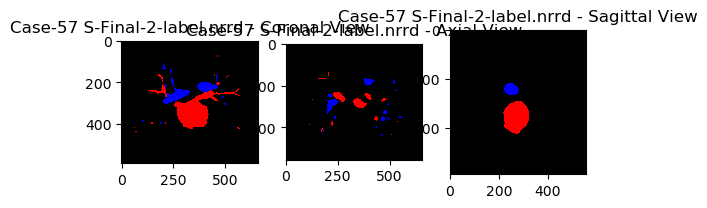

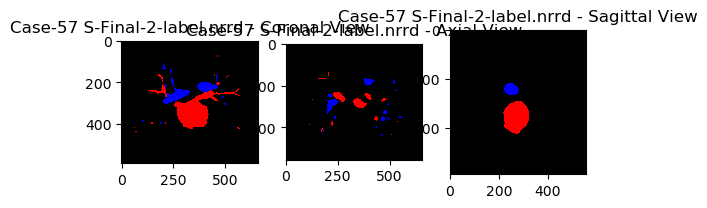

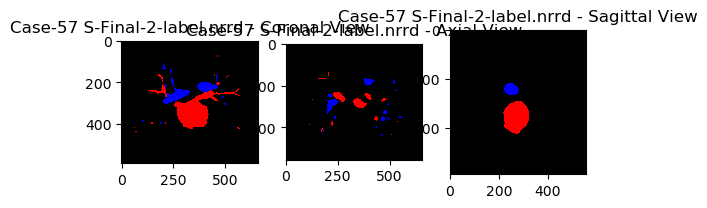

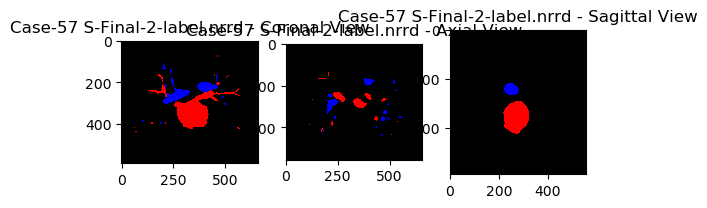

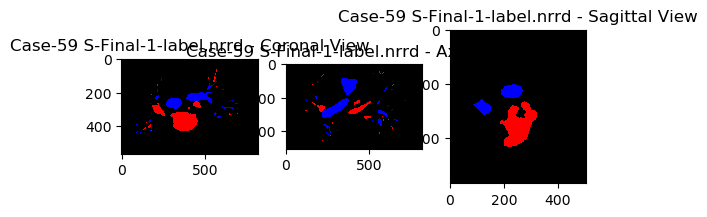

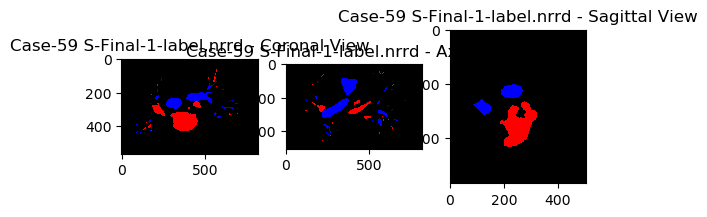

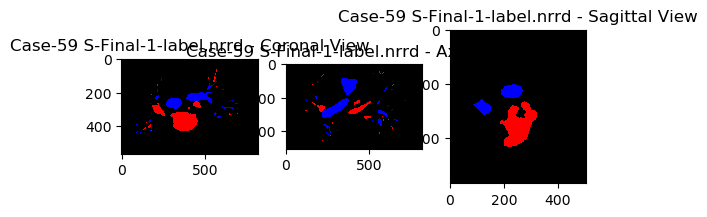

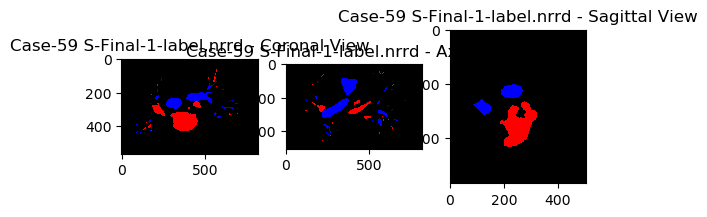

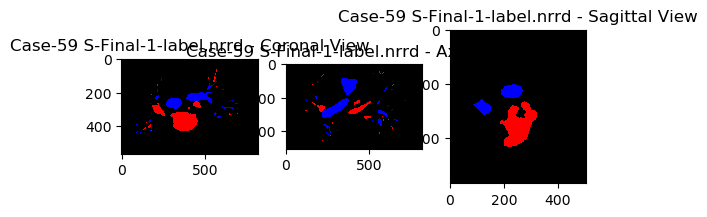

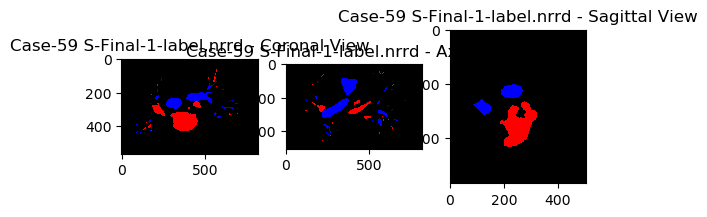

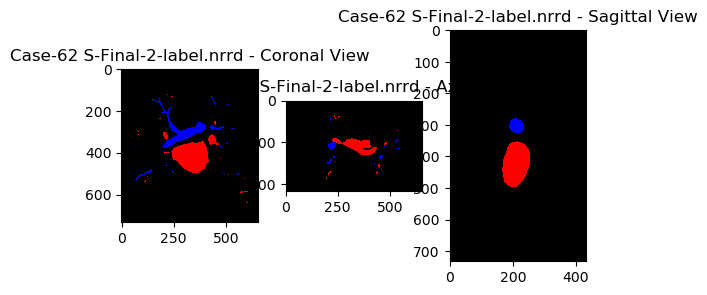

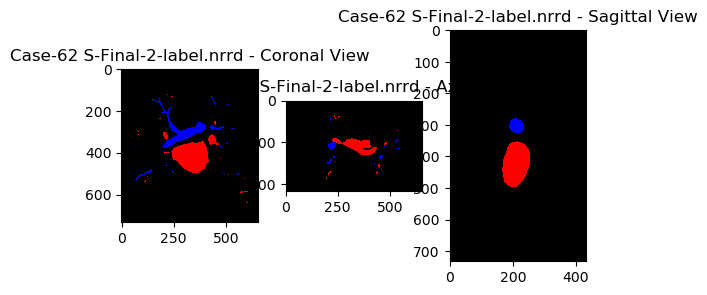

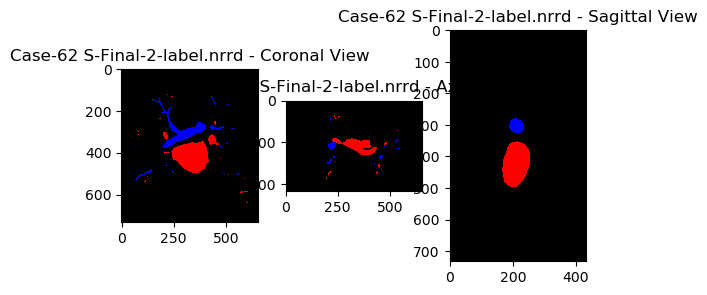

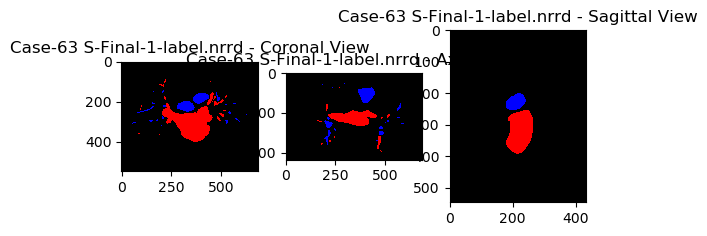

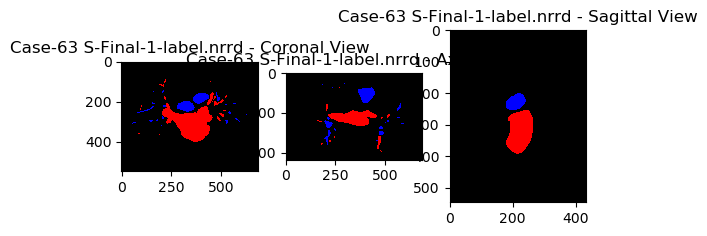

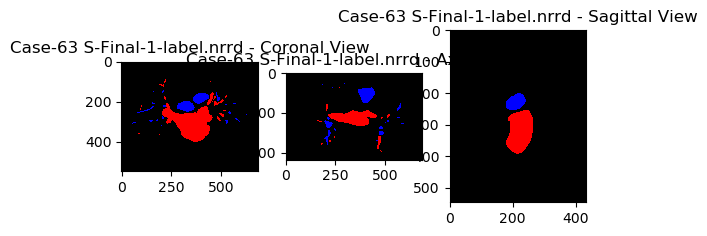

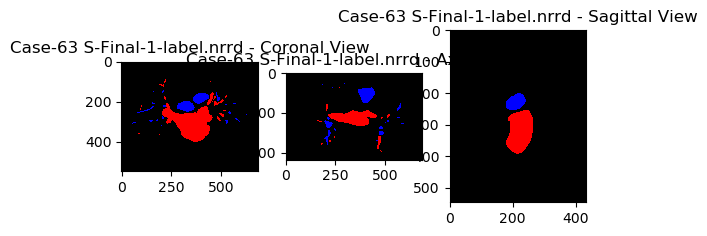

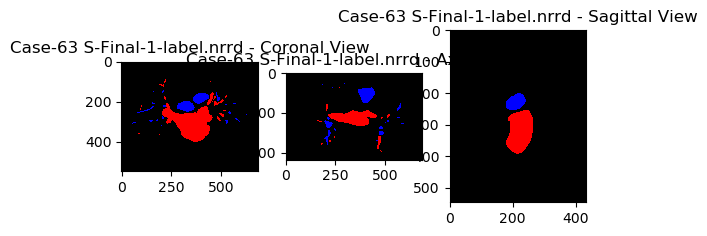

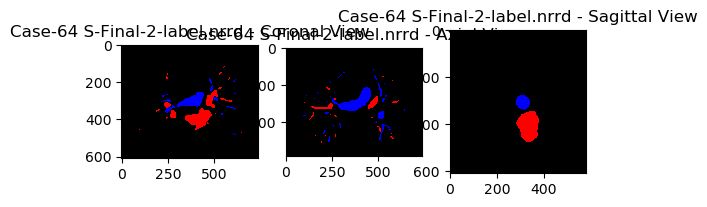

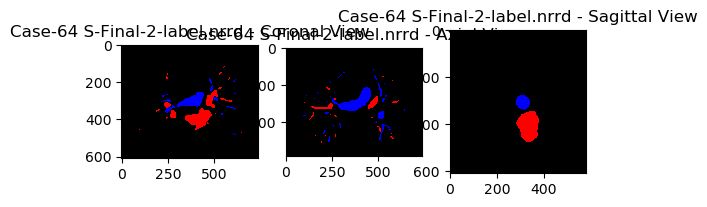

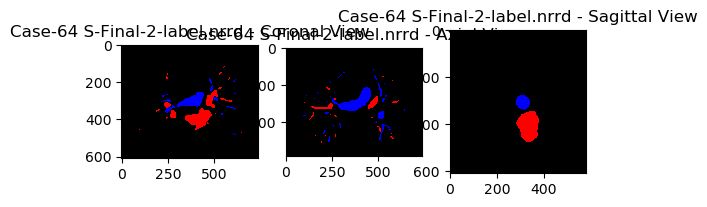

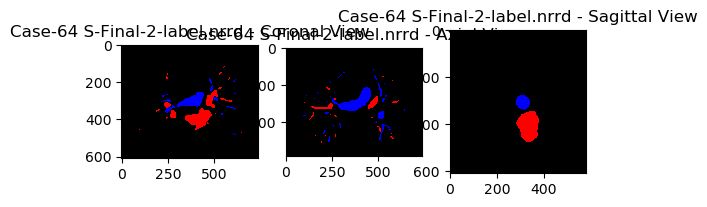

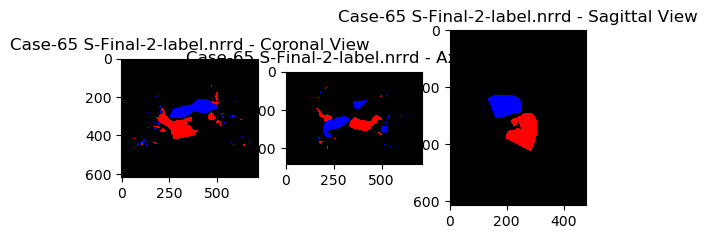

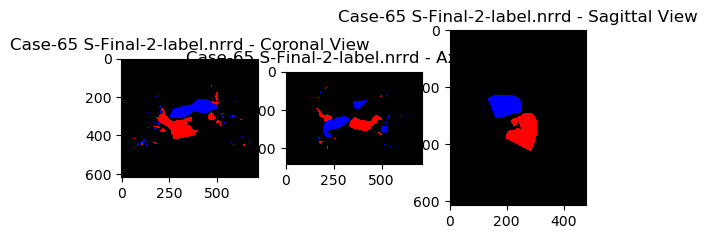

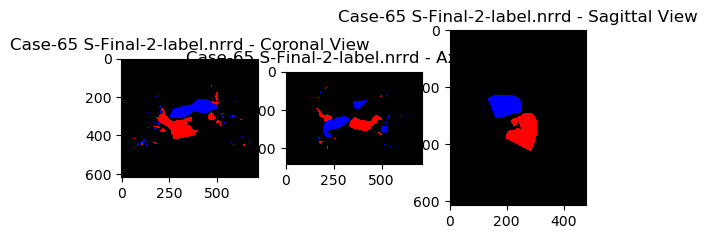

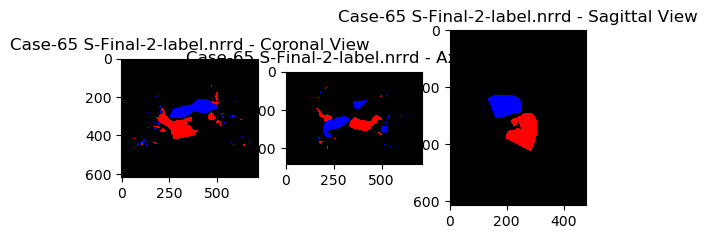

IndexError: list index out of range

: 

In [24]:
########################
# RUN THIS SECOND
########################

import os
import re
import shutil
import numpy as np
import nrrd
import matplotlib.pyplot as plt


# Input: list of inputs of 1 case aka list of 1 batch (could be NN = 2, 3, 11, etc)
# Input 2: single target label file (final)
# Input 3: list of other group's file paths (if 'files' is 'S-Final-' list, 'all_paths' is 'S-Segmentation-' list)
# Output: All NN input/output files copied
def process_files(files, new_dir, all_paths):

    for file_path in files:

        caseNum = ''
        # Get the base filename without the path
        original_name = os.path.basename(file_path)
        
        # Extract case number and following numbers from the path
        match = re.search(r'Case-(\d+)', file_path)
        if match:
            caseNum = match.group(1)
        
        # Stores list of all numeric strings found in the current file path
        numList = re.findall(r'\d+', file_path)
        
        # Appends case number to 'Case-' string, used for finding the number of segmentation files for a given case #
        caseAndNum = 'Case-' + caseNum

        # Initializes variables for 'if' statement
        new_filename = ""
        source_path = ""
        destination_path = ""
        new_label_filename = ""
        destination_label_path = ""

        # Gets segmentation file number
        pattern = r"S-Segmentation-(\d+)"
        numMatches = re.findall(pattern, original_name)

        # Checks the number of times 'Case-##' and 'S-Segmentation-' both appear in a string to determine how many copies of 'S-Final-' to make, and increment their number correctly
        count = 0
        for file in all_paths:
            # Could enforce .lowercase() when matching strings as a precaution
            if caseAndNum in file and "S-Segmentation-" in file:
                count += 1
                pattern = r"S-Segmentation-(\d+)"
                numMatches += re.findall(pattern, file)

        # Check if file name is 'final' or 'segmentation' to determine where to save the new copy
        if('S-Segmentation-' in original_name):
            # Construct the new filenames
            new_filename = f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{numMatches[0]}.nrrd"
            # Construct the source paths for copying
            source_path = os.path.dirname(file_path + "/" + original_name).replace(os.path.sep, '/')
            # Construct the destination paths for copying
            destination_path = os.path.join(new_dir, new_filename).replace(os.path.sep, '/')

            #############################################################################
            #############################################################################

            # Inserted code - convert segmentation file to labelmap with only 'A' & 'V' labels,
                # Prints plot with axial, coronal, sagittal view of center 2D slicers of input file
            
            data, header = nrrd.read(file_path)

            VValue_count = 0
            AValue_count = 0
                        # Outputs header key/value list
            for key, value in header.items():
                try:
                    if   value == '0.847059 0.396078 0.309804': 
                        VValue = header[key[0:-6] + '_LabelValue']
                        print('Vein Segmentation found for: [' + caseAndNum + '] ' + os.path.basename(file_path))
                        VValue_count += 1
                    elif value == '0 0.592157 0.807843': 
                        AValue = header[key[0:-6] + '_LabelValue']
                        print('Artery Segmentation found for: [' + caseAndNum + '] ' + os.path.basename(file_path))
                        AValue_count += 1
                except Exception:
                    print("Expected segmentation volumes 'Artery' & 'Vein' not found.")
            
            # Checks if more than one label with one of the above color values is present in the segmentation, prints path to it if there is
            if VValue_count > 1:
                print("More than one 'vein' label detected: " + new_filename)
            elif AValue_count > 1:
                print("More than one 'artery' label detected: " + new_filename)

            # Creates new 3D numpy dataset, replaces values of 0 with 1 & 2 where they are present in the input file 
            outputlabelmap = np.zeros_like(data)
            outputlabelmap[np.equal(data, int(AValue))] = 1
            outputlabelmap[np.equal(data, int(VValue))] = 2

            data = outputlabelmap

            # Saves segmentation to labelmap nrrd file
            # nrrd.write(destination_path, outputlabelmap, header)
            # print((f"Copied segmentation -> labelmap file: {source_path} to {destination_path}"))

            #####################################################

            # THIS SECTION IS USED TO GENERATE PLOTS OF THE CENTRAL AXIAL, CORONAL & SAGITTAL VIEWS OF THE INPUT FILE

            # Calculate center indices for the three views
            x_center = data.shape[0] // 2
            y_center = data.shape[1] // 2
            z_center = data.shape[2] // 2

            # Rotates images to help match appearance in 3D Slicer
            coronal_slice = np.rot90(data[:, y_center, :])
            axial_slice = np.rot90(data[:, :, z_center])
            sagittal_slice = np.rot90(data[x_center, :, :])

            # Rotate the axial slice 180 degrees left to right to help match how it appears in 3D Slicer
            axial_slice = np.flip(axial_slice, axis=0)

            # Defines colors for segmentation values
            colors = {
                0: (0, 0, 0),     # Black
                1: (0, 0, 255), # Blue
                2: (255, 0, 0),   # Red
            }

            # Applys colors to slices
            def colorize_slice(slice_data):
                colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
                for value, color in colors.items():
                    colored_slice[slice_data == value] = color
                return colored_slice

            # Displays the slices
            colored_coronal_slice = colorize_slice(coronal_slice)
            colored_axial_slice = colorize_slice(axial_slice)
            colored_sagittal_slice = colorize_slice(sagittal_slice)

            # Creates a 2x2 subplot for the three views
            plt.figure(figsize=(6, 4))

            # Case number, file name, & the specific view is passed to the plot titles
            plt.subplot(1, 3, 1)
            plt.imshow(colored_coronal_slice, cmap='gray')
            plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Coronal View')

            plt.subplot(1, 3, 2)
            plt.imshow(colored_axial_slice, cmap='gray')
            plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Axial View')

            plt.subplot(1, 3, 3)
            plt.imshow(colored_sagittal_slice, cmap='gray')
            plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Sagittal View')

            plt.tight_layout()
            plt.show()

            #######################################################


            
            #############################################################################
            #############################################################################

        elif('S-Final-' in original_name):
            
            # Checks if there is more than 1 S-Segmentation file associated with this labelmap for a given Case-##
            if(count>1):        
                
                # Creates as many copies of the labelmap file as there are S-Segmentation files for a given Case-##
                # NumMatches contains a list of the specific '#' in S-Segmentaion-# file numbers (Ex: '3' in S-Segmentaion-3)
                for i in range(count):
                    # Construct the new filenames
                    new_label_filename = f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{numMatches[i]}.nrrd"
                    # Construct the source paths for copying
                    source_path = os.path.dirname(file_path + "/" + original_name).replace(os.path.sep, '/')
                    # Construct the destination paths for copying
                    destination_label_path = os.path.join(new_dir, "labels", "final", new_label_filename).replace(os.path.sep, '/')

                    # Copy and rename the label file
                    # try:
                    #     shutil.copyfile(source_path, destination_label_path)
                    #     print(f"Copied labelmap file: {source_path} to {destination_label_path}")
                    # except PermissionError:
                    #     print("Permission denied: Unable to copy the file.")

                # THIS SECTION IS USED TO GENERATE PLOTS OF THE CENTRAL AXIAL, CORONAL & SAGITTAL VIEWS OF THE INPUT FILE

                    data, header = nrrd.read(file_path)

                    # Calculate center indices for the three views
                    x_center = data.shape[0] // 2
                    y_center = data.shape[1] // 2
                    z_center = data.shape[2] // 2

                    # Rotates images to help match appearance in 3D Slicer
                    coronal_slice = np.rot90(data[:, y_center, :])
                    axial_slice = np.rot90(data[:, :, z_center])
                    sagittal_slice = np.rot90(data[x_center, :, :])

                    # Rotate the axial slice 180 degrees left to right to help match how it appears in 3D Slicer
                    axial_slice = np.flip(axial_slice, axis=0)

                    # Defines colors for segmentation values
                    colors = {
                        0: (0, 0, 0),     # Black
                        1: (0, 0, 255), # Blue
                        2: (255, 0, 0),   # Red
                        3: (0, 255, 0), # Green
                        4: (0, 255, 255), # Yellow
                        5: (255, 255, 0) # Purple
                    }

                    # Applys colors to slices
                    def colorize_slice(slice_data):
                        colored_slice = np.zeros(slice_data.shape + (3,), dtype=np.uint8)
                        for value, color in colors.items():
                            colored_slice[slice_data == value] = color
                        return colored_slice

                    # Displays the slices
                    colored_coronal_slice = colorize_slice(coronal_slice)
                    colored_axial_slice = colorize_slice(axial_slice)
                    colored_sagittal_slice = colorize_slice(sagittal_slice)

                    # Creates a 2x2 subplot for the three views
                    plt.figure(figsize=(6, 4))

                    # Case number, file name, & the specific view is passed to the plot titles
                    plt.subplot(1, 3, 1)
                    plt.imshow(colored_coronal_slice, cmap='gray')
                    plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Coronal View')

                    plt.subplot(1, 3, 2)
                    plt.imshow(colored_axial_slice, cmap='gray')
                    plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Axial View')

                    plt.subplot(1, 3, 3)
                    plt.imshow(colored_sagittal_slice, cmap='gray')
                    plt.title(caseAndNum + ' ' + os.path.basename(file_path) + ' - Sagittal View')

                    plt.tight_layout()
                    plt.show()
                
        
        
        else:
            print("No match for 'S-Segmentaion-' or 'S-Final-' in path: " + file_path)
            continue
        
        #==========================================
        # Locate and copy the Vx3.nrrd file

        # vx3_source = os.path.join(source_path, "Vx3.nrrd")
        # vx3_destination = os.path.join(new_dir, f"Case-{caseNum}_{numList[np.argmax([len(x) for x in numList])]}_{original_name}_Vx3.nrrd")
        # shutil.copy(vx3_source, vx3_destination)
        # print(f"Copied: {vx3_source} to {vx3_destination}")
        #==========================================


##################################################################################################

# Specify path to 'dataset' directory, following the MONAI file tree folder requirements of datasets -> label -> final
# 'Segmentation' files are placed in the 'dataset' directory, 'final' files are placed in the 'final' directory

#new_dir1 = "C:/Users/Adam/Desktop/Programs/code_testing/python_file_rename_copy/datasetsTest"

new_dir1 = "X:/APPIL/Hoffman-Han-RA4/Dataset_MonaiCore"

##################################################################################################

# Copy and rename 'label' files only
process_files(final_files, new_dir1, segmentation_files)

# Copy and rename 'segmentation' files only
process_files(segmentation_files, new_dir1, final_files)

